# Exploratory Data Analysis (EDA)
## Predicting AI Acceptance in Mental Health Interventions through Self-Determination Theory

This notebook focuses on exploratory data analysis and feature exploration related to our hypotheses.

### Research Questions:
- **H1**: Main Effect - SDT predicts AI Acceptance
- **H2**: Attitudinal Moderation - AI attitudes moderate SDT → AI Acceptance relationship
- **H3**: Cross-Cultural Moderation - Effects stronger in China vs US
- **H4**: Mediation by Epistemic Trust - Epistemic Trust mediates SDT → AI Acceptance


## 0.0 Library Import

In [175]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy import linalg
import warnings
from __future__ import annotations
from pathlib import Path
from typing import Dict, Iterable, List
from pandas.api.types import is_numeric_dtype

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

### Workflow Roadmap
1. Profile raw country datasets to understand schema width and missingness.
2. Augment and coalesce Chinese role-specific responses into a unified table.
3. Align USA data with the coalesced China schema, preserving role-aware fields.
4. Build union, intersection, and merged outputs plus diagnostics to guide modeling.


## 1.0 Data Preprocessing

### 1.2 Chinese data
- We need to integrate Chinese data from 3 separate datasets into 1 unified data

In [ ]:
cn_all = pd.read_csv('data/china/CN_all.csv')
cn_client = pd.read_csv('data/china/CN_client.csv')
cn_therapist = pd.read_csv('data/china/CN_therapist.csv')

load_summary = pd.DataFrame([
    {"dataset": "CN_all", "rows": cn_all.shape[0], "columns": cn_all.shape[1], "missing_pct": cn_all.isna().mean().mean() * 100},
    {"dataset": "CN_client", "rows": cn_client.shape[0], "columns": cn_client.shape[1], "missing_pct": cn_client.isna().mean().mean() * 100},
    {"dataset": "CN_therapist", "rows": cn_therapist.shape[0], "columns": cn_therapist.shape[1], "missing_pct": cn_therapist.isna().mean().mean() * 100}
]).round({"missing_pct": 2})

load_summary

,dataset,rows,columns,missing_pct
0,CN_all,485,514,36.72
1,CN_client,216,565,34.30
2,CN_therapist,269,565,32.69


### 1.2 Coalesce China Client & Therapist Signals
- Append role-specific features, enforce role labels, and collapse paired columns into unified indicators.


**Quick takeaways:**
- Therapist sample carries the widest schema (565 columns) but also the highest average missingness.
- Client data mirrors therapist coverage, ensuring coalesced features can draw from both roles.
- The combined `CN_all` file remains the narrowest input and needs augmentation before analysis.


#### 1.2.1 Compare Column Coverage Across Role-Specific Files
Quantify which features are missing from `cn_all` by contrasting its header with the union of client and therapist surveys.
- **Summary:** Current exports already cover all 565 shared client/therapist columns, leaving only `Country`, `filter_$`, and `role_label` as China-specific fields carried forward for provenance.


In [220]:
all_cols = set(cn_all.columns)
client_cols = set(cn_client.columns)
ther_cols = set(cn_therapist.columns)

union_cols = client_cols | ther_cols
missing_from_all = sorted(list(union_cols - all_cols))
extra_in_all = sorted(list(all_cols - union_cols))

print("Columns to bring into CN_all from CN_client/CN_therapist:", len(missing_from_all))
print("Unique columns present only in CN_all:", len(extra_in_all))
print(extra_in_all)

Columns to bring into CN_all from CN_client/CN_therapist: 0
Unique columns present only in CN_all: 3
['Country', 'filter_$', 'role_label']


#### 1.2.2 Prepare Role-Specific Feature Tables
Subset client and therapist datasets to the missing columns and apply `_client` / `_therapist` suffixes for provenance before merging.
- **Summary:** Both role-specific sources contribute 53 overlapping items, so suffixing ensures we retain role provenance before coalescing.


In [179]:
# Subset each source to [ID] + the columns we intend to append
client_extra_all = [c for c in missing_from_all if c in cn_client.columns]
therapist_extra_all = [c for c in missing_from_all if c in cn_therapist.columns]
client_extra_df = cn_client[["ID"] + client_extra_all].copy()
therapist_extra_df = cn_therapist[["ID"] + therapist_extra_all].copy()

# If any column name is present in both client and therapist extras, create distinct names by adding explicit suffixes to BOTH.
overlap_names = sorted(list(set(client_extra_all).intersection(set(therapist_extra_all))))

# Start by suffixing all appended columns to reflect source
client_renamer = {c: f"{c}_client" for c in client_extra_all}
therapist_renamer = {c: f"{c}_therapist" for c in therapist_extra_all}
client_extra_df = client_extra_df.rename(columns = client_renamer)
therapist_extra_df = therapist_extra_df.rename(columns = therapist_renamer)

print("Overlap original names (before suffixing):", len(overlap_names))
print("Planned appended columns (client):", len(client_renamer))
print("Planned appended columns (therapist):", len(therapist_renamer))

Overlap original names (before suffixing): 53
Planned appended columns (client): 53
Planned appended columns (therapist): 53


#### 1.2.3 Validate Participant IDs
Ensure there are no duplicate `ID` values within client, therapist, or combined datasets before merging.
- **Summary:** ID audits confirm zero duplicates across all three sources, so downstream merges remain one-to-one on `ID`.


In [180]:
# Check for duplicate IDs in sources
dup_client = client_extra_df["ID"].duplicated(keep=False).sum()
dup_therapist = therapist_extra_df["ID"].duplicated(keep=False).sum()
dup_all = cn_all["ID"].duplicated(keep=False).sum()
print("Duplicates by ID: client:", int(dup_client), "therapist:", int(dup_therapist), "all:", int(dup_all))

Duplicates by ID: client: 0 therapist: 0 all: 0


#### 1.2.4 Merge Role-Specific Columns into `cn_all`
Left-join the prepared client and therapist tables onto the all-sample dataframe.
- **Summary:** The augmentation expands `cn_all` from 514 to 620 columns while keeping the participant count fixed at 485.


In [181]:
# Left-join CN_all with client-only extras and therapist-only extras
cn_all_aug = cn_all.merge(client_extra_df, on="ID", how="left")
cn_all_aug = cn_all_aug.merge(therapist_extra_df, on="ID", how="left")

print("Original CN_all shape :", cn_all.shape)
print("Augmented CN_all shape:", cn_all_aug.shape)

Original CN_all shape : (485, 514)
Augmented CN_all shape: (485, 620)


In [182]:
# How many new columns did we add?
added_cols = [c for c in cn_all_aug.columns if c not in cn_all.columns]
print("Number of new columns:", len(added_cols))
print("New Columns Added:", added_cols)

Number of new columns: 106
New Columns Added: ['AI_use_sum_client', 'AIavatar_CO_mean_client', 'AIavatar_EOU_mean_client', 'AIavatar_HC_mean_client', 'AIavatar_HM_mean_client', 'AIavatar_PPR_mean_client', 'AIavatar_SE_mean_client', 'AIavatar_TQE_mean_client', 'AIavatar_mean_client', 'AssistAIClinicalAdmin_client', 'AssistAIClinicalTherapy_client', 'AssistAIResearch_client', 'AssistAI_mean_client', 'AutonAI_client', 'CollabAI_client', 'GAAIS_10r_client', 'GAAIS_5r_client', 'GAAIS_6r_client', 'GAAIS_7r_client', 'GAAIS_8r_client', 'GAAIS_mean_client', 'GAAIS_negr_client', 'HumanTT_CO_mean_client', 'HumanTT_EOU_mean_client', 'HumanTT_HC_mean_client', 'HumanTT_HM_mean_client', 'HumanTT_PPR_mean_client', 'HumanTT_SE_mean_client', 'HumanTT_TQE_mean_client', 'HumanTT_mean_client', 'PHQ5_mean_client', 'WAI_bond_AIavatar_client', 'WAI_bond_AIchatbot_client', 'WAI_bond_TThuman_client', 'WAI_goal_AIavatar_client', 'WAI_goal_AIchatbot_client', 'WAI_goal_TThuman_client', 'WAI_mean_AIavatar_client', 

#### 1.2.5 Inspect Augmented Schema
Confirm the augmented dataframe dimensions and ensure no duplicate column labels remain.
- **Summary:** Post-merge schema holds steady at 485 rows with 620 columns and no duplicate headers, so the augmented frame is ready for coalescing.


In [183]:
print("Rows:", len(cn_all_aug), "Columns:", len(cn_all_aug.columns))
print("\nDuplicate column names:", cn_all_aug.columns.duplicated().sum())

Rows: 485 Columns: 620

Duplicate column names: 0


#### 1.2.6 Construct Role-Aware Coalesced Features
Create unified feature columns using role-aware selection and fallbacks.
- **Summary:** All 565 client/therapist base names align, enabling a clean coalescing pass that preserves every paired construct.


In [184]:
cn = cn_all_aug.copy()
cn.columns = pd.Index(cn.columns).astype(str).str.strip()

def base_name(col: str) -> str:
    c = str(col).strip()
    if c.endswith("_client"):
        return c[:-len("_client")]
    if c.endswith("_therapist"):
        return c[:-len("_therapist")]
    return c

# Collect role-suffixed columns
client_cols_cn = [c for c in cn.columns if c.endswith("_client")]
ther_cols_cn = [c for c in cn.columns if c.endswith("_therapist")]

# Build base-name sets
base_client_cn = {base_name(c) for c in client_cols_cn}
base_ther_cn = {base_name(c) for c in ther_cols_cn}

# Bases that are only in one role
only_client_bases = sorted(base_client_cn - base_ther_cn)
only_ther_bases = sorted(base_ther_cn - base_client_cn)

print("Rows:", cn.shape[0], "Columns:", cn.shape[1])
print("Duplicate column names:", cn.columns.duplicated().sum())

Rows: 485 Columns: 620
Duplicate column names: 0


In [185]:
print("Columns that exist for both roles (count by base):")
paired_bases = sorted(list({base_name(c) for c in client_cols} & {base_name(c) for c in ther_cols}))
print("Paired bases:", len(paired_bases))
paired_bases

Columns that exist for both roles (count by base):
Paired bases: 565


['AI_other_use_text',
 'AI_use_sum',
 'AIavatar_CO_mean',
 'AIavatar_EOU_mean',
 'AIavatar_HC_mean',
 'AIavatar_HM_mean',
 'AIavatar_PPR_mean',
 'AIavatar_SE_mean',
 'AIavatar_TQE_mean',
 'AIavatar_mean',
 'AIuse_1',
 'AIuse_10',
 'AIuse_2',
 'AIuse_3',
 'AIuse_4',
 'AIuse_5',
 'AIuse_6',
 'AIuse_7',
 'AIuse_8',
 'AIuse_9',
 'AssistAIClinicalAdmin',
 'AssistAIClinicalTherapy',
 'AssistAIResearch',
 'AssistAI_mean',
 'AutonAI',
 'Batch_group',
 'Batch_name',
 'CollabAI',
 'ECR_1r',
 'ECR_2r',
 'ECR_3r',
 'ECR_4r',
 'ECR_5',
 'ECR_6',
 'ECR_7',
 'ECR_8',
 'ECR_9',
 'EPO',
 'ET_1',
 'ET_10',
 'ET_11',
 'ET_12',
 'ET_13',
 'ET_14',
 'ET_15',
 'ET_2',
 'ET_3',
 'ET_4',
 'ET_5',
 'ET_6',
 'ET_7',
 'ET_8',
 'ET_9',
 'GAAIS_1',
 'GAAIS_10',
 'GAAIS_10r',
 'GAAIS_2',
 'GAAIS_3',
 'GAAIS_4',
 'GAAIS_5',
 'GAAIS_5r',
 'GAAIS_6',
 'GAAIS_6r',
 'GAAIS_7',
 'GAAIS_7r',
 'GAAIS_8',
 'GAAIS_8r',
 'GAAIS_9',
 'GAAIS_mean',
 'GAAIS_neg',
 'GAAIS_negr',
 'GAAIS_pos',
 'HumanTT_CO_mean',
 'HumanTT_EOU_mea

In [186]:
print("Bases only in client:", len(only_client_bases))
print("Bases only in therapist:", len(only_ther_bases))

Bases only in client: 0
Bases only in therapist: 0


In [187]:
# show any mismatched pairs explicitly
mismatches = []
for b in sorted(base_client_cn | base_ther_cn):
    has_client = (b + "_client") in client_cols_cn
    has_ther = (b + "_therapist") in ther_cols_cn
    if has_client ^ has_ther:
        mismatches.append((b, has_client, has_ther))
print("Mismatched bases:", len(mismatches))
for m in mismatches[:20]:
    print(m)

Mismatched bases: 0


#### 1.2.7 Derive Role Labels
Normalize role indicators so each row identifies `client` vs `therapist` for downstream coalescing.
- **Summary:** Harmonized flags yield 216 client rows and 269 therapist rows, giving the coalescer a reliable role switch.



In [188]:
ROLE_CLIENT = "client"
ROLE_THER = "therapist"

def ensure_role_label(df):
    if "role_label" in df.columns:
        df["role_label"] = df["role_label"].astype(str).str.strip().str.lower()
        return df

    # Try binary therapist flag
    if "therapist" in df.columns:
        t = pd.to_numeric(df["therapist"], errors="coerce").fillna(0).astype(int)
        df["role_label"] = np.where(t == 1, ROLE_THER, ROLE_CLIENT)
        return df

    # Try role_binary (1 = therapist, 0 = client)
    if "role_binary" in df.columns:
        rb = pd.to_numeric(df["role_binary"], errors="coerce").fillna(0).astype(int)
        df["role_label"] = np.where(rb == 1, ROLE_THER, ROLE_CLIENT)
        return df

    # Try free-text role
    if "role" in df.columns:
        s = df["role"].astype(str).str.strip().str.lower()
        df["role_label"] = np.where(s.str.contains("therap"), ROLE_THER, np.where(s.str.contains("client"), ROLE_CLIENT, np.nan))
        return df

    # Fallback
    df["role_label"] = np.nan
    return df

cn = ensure_role_label(cn)
print(cn["role_label"].value_counts(dropna=False))

role_label
therapist    269
client       216
Name: count, dtype: int64


In [189]:
def coalesce_pair(df: pd.DataFrame, base: str) -> pd.Series:
    c_client = f"{base}_client"
    c_ther = f"{base}_therapist"

    # force numeric where possible
    x_client = pd.to_numeric(df[c_client], errors="coerce")
    x_ther = pd.to_numeric(df[c_ther], errors="coerce")

    role = df["role_label"].astype(str).str.lower()

    # role-aware pick
    val = np.where(role.eq("client"), x_client, np.where(role.eq("therapist"), x_ther, np.nan))

    # fallback:
    val = pd.Series(val, index=df.index)
    null_mask = val.isna()
    if null_mask.any():
        fallback = x_client.combine_first(x_ther)
        val.loc[null_mask] = fallback.loc[null_mask]
    return val

#### 1.2.8 Generate Unified Feature Values
Iterate across paired client/therapist bases to populate coalesced columns with role-aware selections and fallbacks.
- **Summary:** Coalescing introduced 53 unified columns (e.g., `AIavatar_mean`, `AssistAIClinicalAdmin`) that collapse role variants while defaulting to whichever side is populated.



In [190]:
unified_cols_created = []
for base in paired_bases:
    if base not in cn.columns:
        cn[base] = coalesce_pair(cn, base)
        unified_cols_created.append(base)

len_unified = len(unified_cols_created)
print(f"Unified columns created: {len_unified}")
if len_unified:
    print("Examples:", unified_cols_created[:10])

Unified columns created: 53
Examples: ['AI_use_sum', 'AIavatar_CO_mean', 'AIavatar_EOU_mean', 'AIavatar_HC_mean', 'AIavatar_HM_mean', 'AIavatar_PPR_mean', 'AIavatar_SE_mean', 'AIavatar_TQE_mean', 'AIavatar_mean', 'AssistAIClinicalAdmin']


#### 1.2.9 Audit Coalesced Coverage
Review non-null counts for unified features to confirm successful consolidation.
- **Summary:** Coverage checks reveal sparse text entries like `mh_bg13_text`, but every unified metric retains at least one populated source column for fallback.


In [191]:
qa = []
for base in paired_bases:
    qa.append({
        "feature": base,
        "non_null_unified": int(cn[base].notna().sum()),
        "has_client_src": f"{base}_client" in cn.columns,
        "has_ther_src": f"{base}_therapist" in cn.columns,
    })

qa_df = pd.DataFrame(qa).sort_values("non_null_unified")
print("Paired features:", len(paired_bases))
print("Unified columns created:", len_unified)
display(qa_df.head(10))

Paired features: 565
Unified columns created: 53


,feature,non_null_unified,has_client_src,has_ther_src
498,mh_bg13_text,0,False,False
25,Batch_group,0,False,False
482,expw_chatbots_text,0,False,False
477,edu_text,0,False,False
497,mh_bg13,0,False,False
537,past_therapyother_text,0,False,False
489,job_text,1,False,False
536,past_therapyother,1,False,False
563,would_you_use_other,2,False,False
528,mh_serviceother,2,False,False


#### 1.2.10 Finalize and Export Coalesced Dataset
Drop redundant source columns, persist the unified file, and log saved output.
- **Summary:** The coalesced export lands at `data/china/CN_all_coalesced.csv` with 485 rows × 568 columns after pruning legacy aggregates.


In [192]:
cn_coalesced = cn.loc[:, [c for c in cn.columns if not (c.endswith("_client") or c.endswith("_therapist"))]].copy()
print("cn_coalesced shape:", cn_coalesced.shape)

# Drop legacy aggregates that conflict with coalesced columns
legacy_conflicts = ["AIuse_sum"]
present_conflicts = [c for c in legacy_conflicts if c in cn_coalesced.columns]
if present_conflicts:
    cn_coalesced = cn_coalesced.drop(columns=present_conflicts)
    print("Dropped legacy columns:", present_conflicts)

# Persist data to processed directory
CHINA_DIR = Path("data/china")
CHINA_DIR.mkdir(parents=True, exist_ok=True)

OUT_FP = CHINA_DIR / "CN_all_coalesced.csv"
cn_coalesced.to_csv(OUT_FP, index=False)
print("Saved:", OUT_FP.as_posix())

cn_coalesced shape: (485, 568)
Dropped legacy columns: ['AIuse_sum']
Saved: data/china/CN_all_coalesced.csv


#### 1.2.11 Document Transformation Outputs
Capture row/column counts at each checkpoint and surface representative column changes.
- **Summary:** The checkpoint table and bar plot confirm that augmentation doubled schema width, coalescing trimmed 107 role-tagged columns, and row counts remained stable end-to-end.


In [193]:
# Summarize workflow checkpoints for China data
stage_summary = pd.DataFrame([
    {
        "stage": "cn_all (raw)",
        "rows": cn_all.shape[0],
        "columns": cn_all.shape[1],
        "new_columns_vs_previous": 0,
        "dropped_columns": 0,
        "notes": "Original survey export"
    },
    {
        "stage": "cn_all_aug (w/ suffixes)",
        "rows": cn_all_aug.shape[0],
        "columns": cn_all_aug.shape[1],
        "new_columns_vs_previous": len(added_cols),
        "dropped_columns": 0,
        "notes": "Merged role-specific features"
    },
    {
        "stage": "cn_coalesced (final)",
        "rows": cn_coalesced.shape[0],
        "columns": cn_coalesced.shape[1],
        "new_columns_vs_previous": len_unified,
        "dropped_columns": len([c for c in cn_all_aug.columns if c.endswith("_client") or c.endswith("_therapist")]) + len(present_conflicts),
        "notes": "Role-aware coalesced columns"
    },
])

In [194]:
print("China Data Workflow Summary")
display(stage_summary)

China Data Workflow Summary


,stage,rows,columns,new_columns_vs_previous,dropped_columns,notes
0,cn_all (raw),485,514,0,0,Original survey export
1,cn_all_aug (w/ suffixes),485,620,106,0,Merged role-specific features
2,cn_coalesced (final),485,567,53,107,Role-aware coalesced columns


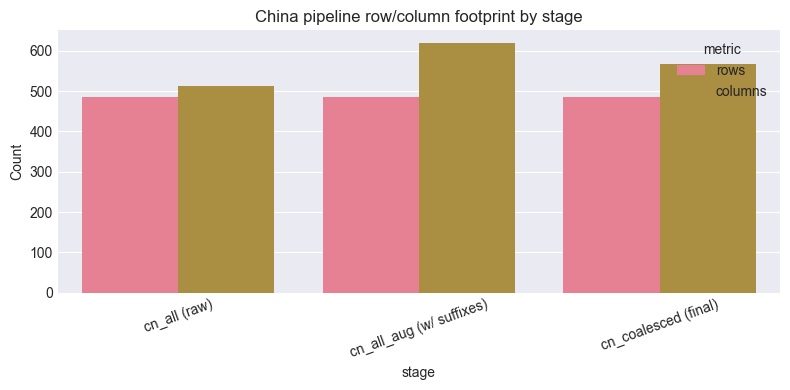

In [195]:
stage_melt = stage_summary.melt(id_vars=['stage', 'notes'], value_vars=['rows', 'columns'], var_name='metric', value_name='count')
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data=stage_melt, x='stage', y='count', hue='metric', ax=ax)
ax.set_title('China pipeline row/column footprint by stage')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=20)
ax.legend(title='metric')
fig.tight_layout()

**China preprocessing highlights:**
- Augmented stage adds 106 role-tagged columns, doubling schema width without changing row count.
- Coalescing collapses 107 redundant role columns while retaining 53 unified features for modeling.
- No stage introduces row loss, so downstream merges can rely on a full cohort of 485 participants.

In [196]:
print("Coalesced features created:")
display(pd.Series(unified_cols_created).sort_values().head(10))

Coalesced features created:


0               AI_use_sum
1         AIavatar_CO_mean
2        AIavatar_EOU_mean
3         AIavatar_HC_mean
4         AIavatar_HM_mean
5        AIavatar_PPR_mean
6         AIavatar_SE_mean
7        AIavatar_TQE_mean
8            AIavatar_mean
9    AssistAIClinicalAdmin
dtype: object

In [197]:
if present_conflicts:
    print("Legacy columns removed:")
    display(pd.Series(present_conflicts))

Legacy columns removed:


0    AIuse_sum
dtype: object

In [198]:
print("Columns exclusive to augmented dataset")
aug_only_cols = sorted(set(cn_all_aug.columns) - set(cn_all.columns))
display(pd.Series(aug_only_cols).head(10))

Columns exclusive to augmented dataset


0              AI_use_sum_client
1           AI_use_sum_therapist
2        AIavatar_CO_mean_client
3     AIavatar_CO_mean_therapist
4       AIavatar_EOU_mean_client
5    AIavatar_EOU_mean_therapist
6        AIavatar_HC_mean_client
7     AIavatar_HC_mean_therapist
8        AIavatar_HM_mean_client
9     AIavatar_HM_mean_therapist
dtype: object

In [199]:
print("Columns retained in final coalesced dataset")
final_cols_sample = pd.Series(sorted(cn_coalesced.columns)).head(10)
display(final_cols_sample)

Columns retained in final coalesced dataset


0    AI_other_use_text
1           AI_use_sum
2     AIavatar_CO_mean
3    AIavatar_EOU_mean
4     AIavatar_HC_mean
5     AIavatar_HM_mean
6    AIavatar_PPR_mean
7     AIavatar_SE_mean
8    AIavatar_TQE_mean
9        AIavatar_mean
dtype: object

### 1.3 Harmonize USA & China Tables
- **Objective:** Align the USA export with the coalesced China schema to enable shared modeling outputs.

In [200]:
usa_all = pd.read_csv('data/usa/USA_all.csv')
print(f"USA All: {usa_all.shape}")

USA All: (1857, 624)


In [201]:
cn_coalesced = pd.read_csv('data/china/CN_all_coalesced.csv')
print(f"China Coalesced: {cn_coalesced.shape}")

China Coalesced: (485, 567)


- **Summary:** USA export provides 1,857 rows × 624 columns, while the coalesced China table contributes 485 rows × 567 columns for cross-country alignment.


In [202]:
usa_cols = set(usa_all.columns)
cn_cols = set(cn_coalesced.columns)

common_cols = sorted(usa_cols & cn_cols)
usa_only = sorted(usa_cols - cn_cols)
cn_only = sorted(cn_cols - usa_cols)

print(f"Common columns: {len(common_cols)}")
print(f"USA-only columns: {len(usa_only)}")
print(f"China-only columns: {len(cn_only)}")


Common columns: 248
USA-only columns: 376
China-only columns: 319


- **Summary:** Intersection analysis surfaces 248 shared columns, alongside 376 USA-only and 319 China-only fields that will later be suffixed in the merged outputs.


In [203]:
# Align legacy helper variables for compatibility
client_cols = client_cols_cn
ther_cols = ther_cols_cn

In [204]:
usa_common = usa_all[common_cols].copy()
cn_common = cn_coalesced[common_cols].copy()

In [205]:
display(common_cols)

['AI_use_sum',
 'AIavatar_CO_mean',
 'AIavatar_EOU_mean',
 'AIavatar_HC_mean',
 'AIavatar_HM_mean',
 'AIavatar_PPR_mean',
 'AIavatar_SE_mean',
 'AIavatar_TQE_mean',
 'AIavatar_mean',
 'AssistAIClinicalAdmin',
 'AssistAIClinicalTherapy',
 'AssistAIResearch',
 'AssistAI_mean',
 'AutonAI',
 'CollabAI',
 'ET_1',
 'ET_10',
 'ET_11',
 'ET_12',
 'ET_13',
 'ET_14',
 'ET_15',
 'ET_2',
 'ET_3',
 'ET_4',
 'ET_5',
 'ET_6',
 'ET_7',
 'ET_8',
 'ET_9',
 'GAAIS_1',
 'GAAIS_10',
 'GAAIS_2',
 'GAAIS_3',
 'GAAIS_4',
 'GAAIS_5',
 'GAAIS_6',
 'GAAIS_7',
 'GAAIS_8',
 'GAAIS_9',
 'GAAIS_neg',
 'GAAIS_pos',
 'HumanTT_CO_mean',
 'HumanTT_EOU_mean',
 'HumanTT_HC_mean',
 'HumanTT_HM_mean',
 'HumanTT_PPR_mean',
 'HumanTT_SE_mean',
 'HumanTT_TQE_mean',
 'HumanTT_mean',
 'P__format_by_problem_10_1',
 'P__format_by_problem_10_2',
 'P__format_by_problem_10_3',
 'P__format_by_problem_10_4',
 'P__format_by_problem_10_5',
 'P__format_by_problem_11_1',
 'P__format_by_problem_11_2',
 'P__format_by_problem_11_3',
 'P__form

In [206]:
dtype_comparison = pd.DataFrame({
    'USA_dtype': usa_common.dtypes,
    'CN_dtype': cn_common.dtypes
})
dtype_mismatch = dtype_comparison[dtype_comparison['USA_dtype'] != dtype_comparison['CN_dtype']]
print(f"Columns with different dtypes: {dtype_mismatch.shape[0]}")
dtype_mismatch.head(20)

Columns with different dtypes: 0


,USA_dtype,CN_dtype


- **Summary:** Dtype parity across the 248 shared features eliminates the need for additional casting prior to concatenation.


In [ ]:
numeric_cols = usa_common.select_dtypes(include='number').columns
value_diff = pd.DataFrame({
    'USA_mean': usa_common[numeric_cols].mean(),
    'CN_mean': cn_common[numeric_cols].mean(),
    'Diff': usa_common[numeric_cols].mean() - cn_common[numeric_cols].mean()
}).sort_values('Diff', key=abs, ascending=False)
value_diff.head(10)

,USA_mean,CN_mean,Diff
SSRPH_2,0.570629,2.280412,-1.709784
ET_12,2.777778,4.476289,-1.698511
SSRPH_4,0.808961,2.486598,-1.677637
ET_5,2.859259,4.478351,-1.619091
ET_6,3.048148,4.562887,-1.514738
clin_exp,5.894737,4.402532,1.492205
SSRPH_5,0.868699,2.247423,-1.378723
SSRPH_3,1.008712,2.319588,-1.310876
Stages_AI_attitudes_26,2.209690,3.486598,-1.276908
TENS_Life_9,3.601578,4.806186,-1.204608


- **Summary:** Mean deltas highlight larger stigma (`SSRPH`) and epistemic-trust (`ET_*`) gaps across countries, reinforcing the need for country-aware modeling.


#### 1.3.2 Build Merge Variants
- **Summary:** Reload both countries' tables and prepare the suffix-aware renamers that power the union, intersection, and merged outputs.

In [208]:
usa_all = pd.read_csv('data/usa/USA_all.csv')
cn_all  = pd.read_csv('data/china/CN_all_coalesced.csv')

usa_cols = set(usa_all.columns)
cn_cols  = set(cn_all.columns)

common_cols = sorted(usa_cols & cn_cols)
usa_only    = sorted(usa_cols - cn_cols)
cn_only     = sorted(cn_cols - usa_cols)

In [209]:
# --- add country labels ---
usa_all = usa_all.copy()
cn_all  = cn_all.copy()
usa_all['Country'] = 'USA'
cn_all['Country']  = 'China'

In [210]:
# --- rename country-specific columns to avoid name clashes in union merge ---
def append_country_suffix(col: str, suffix: str) -> str:
    return col if col.endswith(suffix) else f"{col}{suffix}"

usa_renamer = {c: append_country_suffix(c, "_USA") for c in usa_only}
cn_renamer  = {c: append_country_suffix(c, "_CN")  for c in cn_only}
usa_renamed = usa_all.rename(columns=usa_renamer)
cn_renamed  = cn_all.rename(columns=cn_renamer)

- Columns to keep in final union dataset:
- Country
- all common (unsuffixed)
- all USA-only with _USA
- all CN-only with _CN

In [211]:
final_cols = (['Country'] + common_cols + [usa_renamer[c] for c in usa_only] + [cn_renamer[c] for c in cn_only])

# Make sure both frames have all final columns (fill missing with NaN)
usa_ready = usa_renamed.reindex(columns=final_cols)
cn_ready  = cn_renamed.reindex(columns=final_cols)

In [212]:
# union dataset with country-specific extras preserved
combined_union = pd.concat([usa_ready, cn_ready], ignore_index=True)
combined_union = combined_union.convert_dtypes()

# also build an intersection dataset for pooled modeling
combined_intersection = pd.concat(
    [usa_all[['Country'] + common_cols], cn_all[['Country'] + common_cols]],
    ignore_index=True
).convert_dtypes()

In [ ]:
# --- quick diagnostics ---
def coverage(df, cols, label):
    if not cols:
        return pd.Series(dtype=float, name=label)
    return df[cols].isna().mean().rename(label)

coverage_union = pd.concat([
    coverage(usa_ready, common_cols, 'USA_common_missing_%'),
    coverage(cn_ready, common_cols, 'CN_common_missing_%')
], axis=1) * 100

usa_suffix_cols = [usa_renamer[c] for c in usa_only]
cn_suffix_cols = [cn_renamer[c] for c in cn_only]

suffix_coverages = []
if usa_suffix_cols:
    suffix_coverages.append(coverage(usa_ready, usa_suffix_cols, 'USA_suffix_missing_%'))
if cn_suffix_cols:
    suffix_coverages.append(coverage(cn_ready, cn_suffix_cols, 'CN_suffix_missing_%'))

coverage_suffix = pd.concat(suffix_coverages, axis=1, join='outer') * 100 if suffix_coverages else pd.DataFrame()

summary = pd.DataFrame({
    'common_cols': [len(common_cols)],
    'usa_only_cols': [len(usa_only)],
    'cn_only_cols': [len(cn_only)],
    'combined_union_rows': [combined_union.shape[0]],
    'combined_union_cols': [combined_union.shape[1]],
    'combined_intersection_rows': [combined_intersection.shape[0]],
    'combined_intersection_cols': [combined_intersection.shape[1]],
    'merged_rows': [np.nan],
    'merged_cols': [np.nan],
})

In [214]:
# --- column map for transparency ---
col_map_rows = (
    [(c, c, 'common') for c in common_cols] +
    [(c, f"{c}_USA", 'usa_only_USA') for c in usa_only] +
    [(c, f"{c}_CN",  'cn_only_CN')  for c in cn_only]
)
column_map = pd.DataFrame(col_map_rows, columns=['original_name', 'final_name', 'category'])

In [ ]:
outdir = Path('data/merged'); outdir.mkdir(parents=True, exist_ok=True)

cn_with_roles = cn.copy().assign(Country='China')
usa_with_roles = usa_all.copy().assign(Country='USA')

merged_cols = ['Country'] + sorted((set(usa_with_roles.columns) | set(cn_with_roles.columns)) - {'Country'})

us_cn_merged = pd.concat([usa_with_roles.reindex(columns=merged_cols), cn_with_roles.reindex(columns=merged_cols)], ignore_index=True).convert_dtypes()

summary['merged_rows'] = us_cn_merged.shape[0]
summary['merged_cols'] = us_cn_merged.shape[1]

combined_union.to_csv(outdir / 'US_CN_union_with_suffix.csv', index=False)
combined_intersection.to_csv(outdir / 'US_CN_intersection.csv', index=False)
coverage_union.to_csv(outdir / 'US_CN_common_missingness.csv')
if not coverage_suffix.empty:
    coverage_suffix.to_csv(outdir / 'US_CN_suffix_missingness.csv')
dtype_summary = combined_union.dtypes.rename('dtype').rename_axis('column').reset_index()
dtype_summary.to_csv(outdir / 'US_CN_union_dtypes.csv', index=False)
column_map.to_csv(outdir / 'US_CN_column_map.csv', index=False)
us_cn_merged.to_csv(outdir / 'US_CN_merged.csv', index=False)
summary.to_csv(outdir / 'US_CN_merge_summary.csv', index=False)

In [216]:
summary

,common_cols,usa_only_cols,cn_only_cols,combined_union_rows,combined_union_cols,combined_intersection_rows,combined_intersection_cols,merged_rows,merged_cols
0,248,376,319,2342,944,2342,249,2342,1051


In [217]:
dataset_shapes = pd.Series({
    'US_CN_union_with_suffix': combined_union.shape,
    'US_CN_intersection': combined_intersection.shape,
    'US_CN_merged': us_cn_merged.shape
}).rename('shape')
dataset_shapes

US_CN_union_with_suffix     (2342, 944)
US_CN_intersection          (2342, 249)
US_CN_merged               (2342, 1051)
Name: shape, dtype: object

In [218]:
coverage_snapshot = coverage_union.sort_values('USA_common_missing_%', ascending=False).head(10)
display(coverage_snapshot)

if not coverage_suffix.empty:
    suffix_snapshot = coverage_suffix.sort_values(by=list(coverage_suffix.columns), ascending=False).head(10)
    display(suffix_snapshot)

merged_shape = {
    'union_shape': combined_union.shape,
    'intersection_shape': combined_intersection.shape,
    'merged_shape': us_cn_merged.shape
}
merged_shape

,USA_common_missing_%,CN_common_missing_%
T__format_by_problem_2_4,99.784599,96.494845
T__format_by_problem_3_4,99.730749,96.288660
T__format_by_problem_13_4,99.730749,97.113402
T__format_by_problem_9_4,99.623048,96.288660
T__format_by_problem_8_4,99.623048,96.082474
T__format_by_problem_4_4,99.623048,95.876289
T__format_by_problem_7_4,99.569198,96.701031
T__format_by_problem_12_4,99.569198,96.082474
T__format_by_problem_14_4,99.353796,96.494845
T__format_by_problem_10_4,99.299946,95.670103


,USA_suffix_missing_%,CN_suffix_missing_%
ExternalReference_USA,100.000000,NaN
Live_4_TEXT_USA,100.000000,NaN
Q107_4_TEXT_USA,100.000000,NaN
RecipientFirstName_USA,100.000000,NaN
RecipientLastName_USA,100.000000,NaN
Q6_4_USA,99.784599,NaN
Q6_7_USA,99.784599,NaN
Q107_USA,99.676898,NaN
Exp_with_AI_chatbots_3_TEXT_USA,99.623048,NaN
Gender_4_TEXT_USA,99.623048,NaN


{'union_shape': (2342, 944),
 'intersection_shape': (2342, 249),
 'merged_shape': (2342, 1051)}

**Cross-country merge insights:**
- Only 248 features overlap perfectly; 695 suffixed columns preserve country-specific context without naming conflicts.
- USA responses dominate row counts (1857 vs. 485), so analyses on the union should weight or stratify by `Country`.
- Highest missingness in shared features clusters around stigma (`SSRPH`) and epistemic-trust items, motivating imputation plans before modeling.


**Final merge summary:**
- `US_CN_union_with_suffix.csv` retains 944 columns and both countries' coverage for shared analytics.
- `US_CN_intersection.csv` narrows to 249 columns for strict comparability across 2,342 rows.
- `US_CN_merged.csv` includes 2,342 rows with coalesced features plus 695 role-specific extras, enabling flexible feature selection downstream.
